In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tqdm.notebook import tqdm
from PIL import Image

import torch
import torchvision.transforms as T
import timm

from sklearn.metrics import f1_score

In [3]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = 'mps'

# Custom Dataset

In [6]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, classes, transforms):
        self.data = []
        self.transforms = transforms
        for i, cls in enumerate(classes):
            cls_path = os.path.join(root_path, cls)
            img_list = os.listdir(cls_path)
            for img in img_list:
                if img != '.DS_Store':
                    img_path = os.path.join(cls_path, img)
                    self.data.append((img_path, i))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx][0]).convert('RGB')
        img = self.transforms(img)
        label = self.data[idx][1]

        return img, label

In [7]:
classes = ['real', 'styletransfer']
transforms = T.Compose([
    T.Resize((112, 112)),
    T.ToTensor()
])

total_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part1/chapter1/8/data/train', classes, transforms)
len(total_dataset)

865

In [9]:
total_num = len(total_dataset)
train_num, valid_num, test_num = int(total_num*0.8), int(total_num*0.1), int(total_num*0.1)

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(total_dataset, [train_num+1, valid_num, test_num])

In [10]:
print(len(train_dataset), len(valid_dataset), len(test_dataset))

693 86 86


In [11]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# training, evaluation

In [12]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, preds = torch.max(probs, 1)
        train_accuracy += (preds == labels).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}] Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataset)

    return model, train_loss, train_accuracy

def evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, preds = torch.max(probs, 1)
            valid_accuracy += (preds == labels).sum().item()

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}] Loss: {loss.item():.4f}')

    valid_loss /= len(valid_dataloader)
    valid_accuracy /= len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs):
    model.to(device)
    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}')

    return model

# model

In [13]:
model = timm.create_model(
    'resnet18',
    pretrained=True,
    num_classes=len(classes)
)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [14]:
for parameter in model.parameters():
    parameter.requires_grad = False

for parameter in model.fc.parameters():
    parameter.requires_grad = True

In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 10)

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.6112698885527524, Train Accuracy: 0.6897546897546898, Valid Loss: 0.5563890933990479, Valid Accuracy: 0.7093023255813954


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.4942668337713588, Train Accuracy: 0.8398268398268398, Valid Loss: 0.451658695936203, Valid Accuracy: 0.813953488372093


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.41701121492819354, Train Accuracy: 0.86002886002886, Valid Loss: 0.383727769056956, Valid Accuracy: 0.8837209302325582


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.37597681988369336, Train Accuracy: 0.9177489177489178, Valid Loss: 0.3511365254720052, Valid Accuracy: 0.8953488372093024


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.3226520906795155, Train Accuracy: 0.922077922077922, Valid Loss: 0.31623881061871845, Valid Accuracy: 0.8837209302325582


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.3025424534624273, Train Accuracy: 0.935064935064935, Valid Loss: 0.2883147994677226, Valid Accuracy: 0.8837209302325582


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.27845241061665793, Train Accuracy: 0.9307359307359307, Valid Loss: 0.2702190975348155, Valid Accuracy: 0.8837209302325582


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.2604737214066766, Train Accuracy: 0.9393939393939394, Valid Loss: 0.2568733294804891, Valid Accuracy: 0.8953488372093024


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.23350492932579733, Train Accuracy: 0.9668109668109668, Valid Loss: 0.23387411733468375, Valid Accuracy: 0.9302325581395349


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.2182133604179729, Train Accuracy: 0.9581529581529582, Valid Loss: 0.23031774163246155, Valid Accuracy: 0.9302325581395349


# test

In [17]:
model.eval()
test_loss = 0.0
test_accuracy = 0
total_preds = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, preds = torch.max(probs, 1)
        test_accuracy += (preds == labels).sum().item()

        total_preds.extend(preds.cpu().numpy())

test_loss /= len(test_dataloader)
test_accuracy /= len(test_dataset)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

  0%|          | 0/3 [00:00<?, ?it/s]

Test Loss: 0.25063565870126087, Test Accuracy: 0.9534883720930233


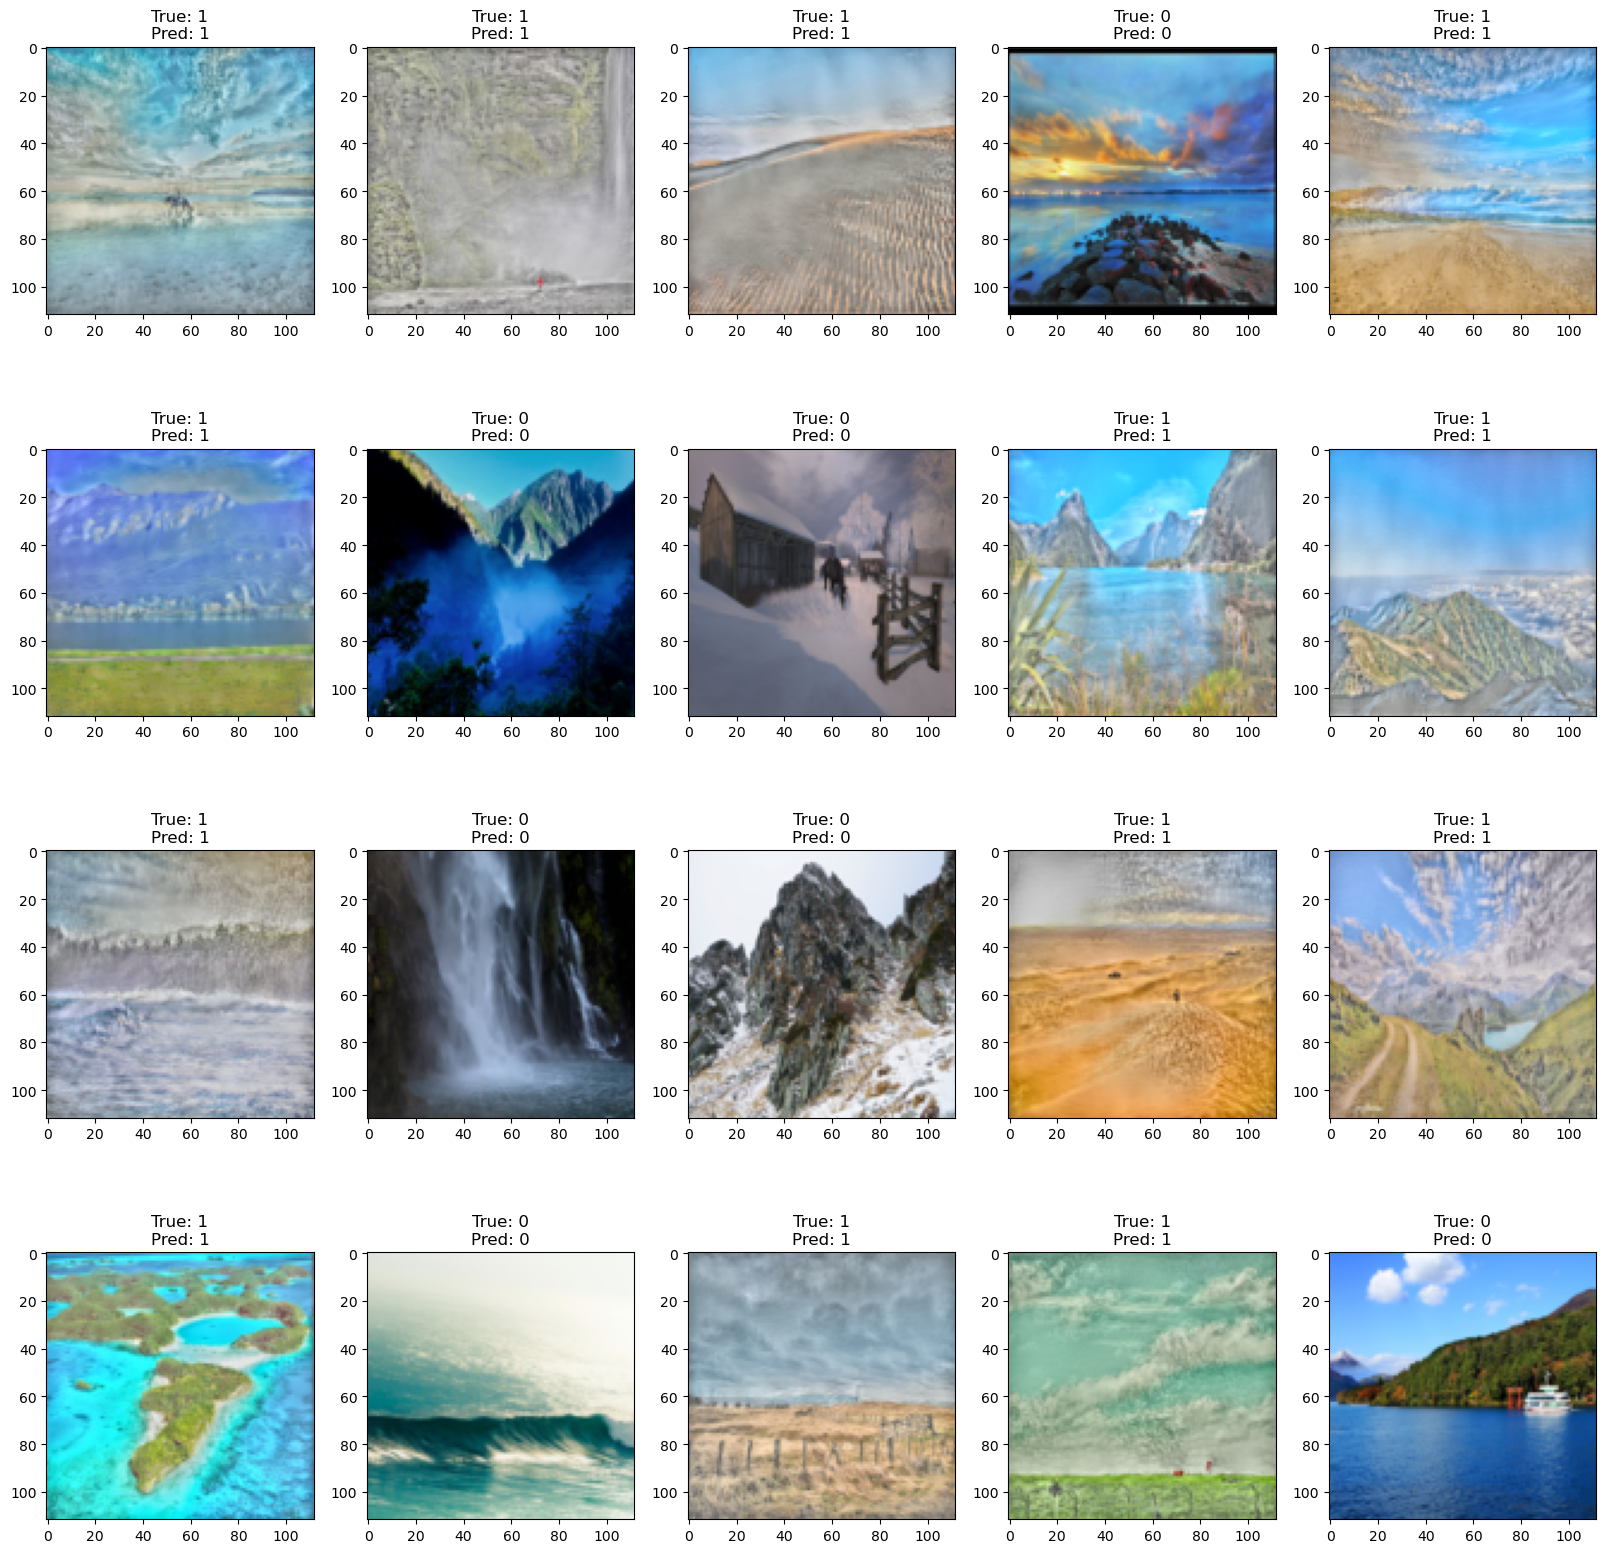

In [18]:
plt.figure(figsize=(20, 20))

for i in range(20):
    plt.subplot(4, 5, i+1)
    img = test_dataset[i][0]
    label = test_dataset[i][1]
    pred = total_preds[i]

    plt.imshow(img.permute(1, 2, 0))
    plt.title(f'True: {label}\nPred: {pred}')